In [1]:
import SITSpinOneMFT as sit
import numpy as np 
from scipy import integrate as intg
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as mclr


In [49]:
Lx = 6
Ly = 6
Ej = 1.
Ec = sit.xymodel.generate_Ec_disorder(Lx,Ly,3.,3.4)

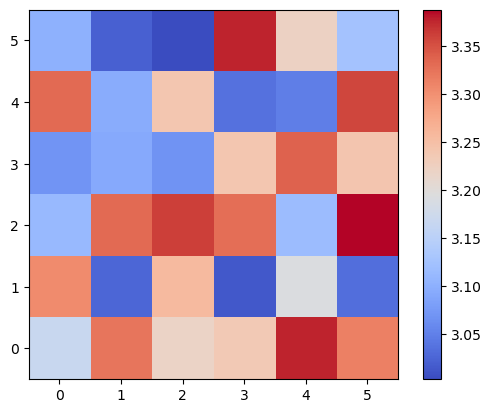

In [50]:
plt.imshow(Ec,origin='lower',cmap='coolwarm')
plt.colorbar()
plt.show()

In [51]:
model = sit.xymodel(Lx,Ly,Ej,Ec)

In [52]:
dt = model.find_GS(niter=4,stepsize=0.1)

In [53]:
print(dt)

8.70222806930542


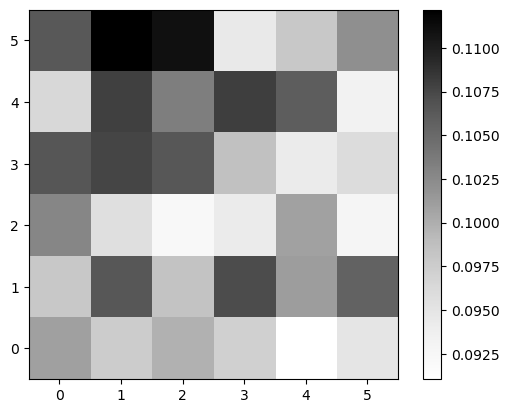

In [54]:
plt.imshow(sit.xymodel.charge_squared(model.gs_wf),origin='lower',cmap='Greys')
plt.colorbar()
plt.show()

In [55]:
flux = np.pi/4.
echo_times = np.array([0.,50.,100.])
nsample = 150
sample_times = np.linspace(-2.,echo_times[-1]+2.,nsample)

In [56]:
hahn_echo_p = sit.xyecho(model,echo_times,flux,sample_times)
hahn_echo_m = sit.xyecho(model,echo_times,-flux,sample_times)

In [57]:
hahn_echo_p.calc_echo()
hahn_echo_m.calc_echo()

In [58]:
c2_vs_t_p = sit.xymodel.charge_squared(hahn_echo_p.wf)
c2_vs_t_m = sit.xymodel.charge_squared(hahn_echo_m.wf)

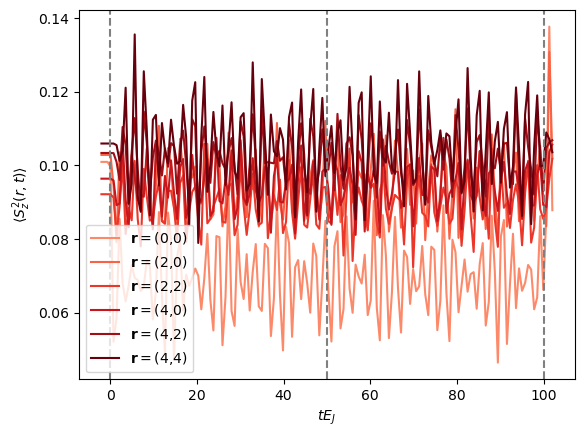

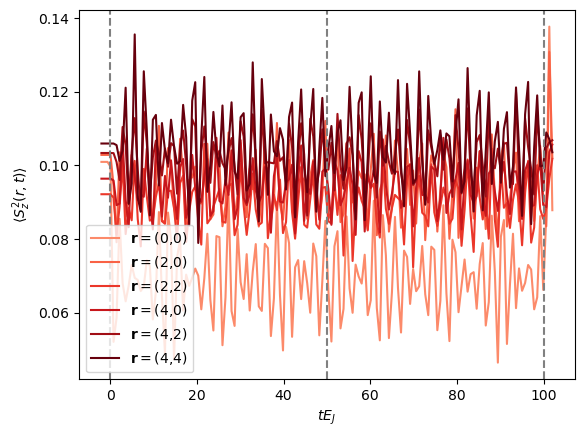

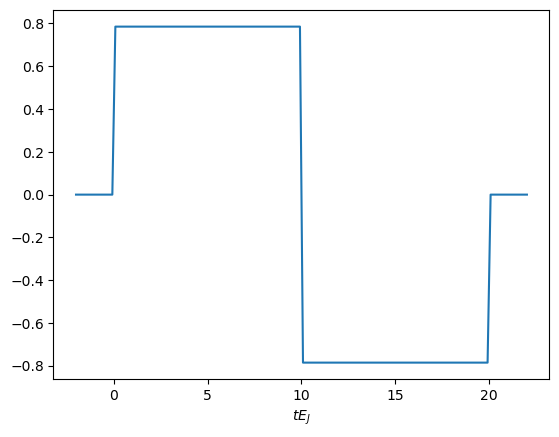

In [60]:
sites = [[0,0],[2,0],[2,2],[4,0],[4,2],[4,4]]
clrs = cm.Reds(np.linspace(0.4,1.,len(sites)))
for i in range(len(sites)):
    plt.plot(hahn_echo_p.sample_times,c2_vs_t_p[sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_z^2(r,t)\rangle$')
plt.axvline(echo_times[0],linestyle='dashed',color='gray')
plt.axvline(echo_times[1],linestyle='dashed',color='gray')
plt.axvline(echo_times[2],linestyle='dashed',color='gray')
plt.legend()
plt.show()

for i in range(len(sites)):
    plt.plot(hahn_echo_m.sample_times,c2_vs_t_m[sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_z^2(r,t)\rangle$')
plt.axvline(echo_times[0],linestyle='dashed',color='gray')
plt.axvline(echo_times[1],linestyle='dashed',color='gray')
plt.axvline(echo_times[2],linestyle='dashed',color='gray')
plt.legend()
plt.show()

plt.plot(hahn_echo_p.sample_times,np.array([ hahn_echo_p.quench_function(t) for t in hahn_echo.sample_times]))
plt.plot(hahn_echo_m.sample_times,np.array([ hahn_echo_m.quench_function(t) for t in hahn_echo.sample_times]))
plt.xlabel(r'$tE_J$')
plt.show()

In [61]:
Loschmidt_echo = np.prod(sit.xymodel.overlap(hahn_echo_p.wf,hahn_echo_m.wf),axis=(0,1))
Loschmidt_echo.shape

(150,)

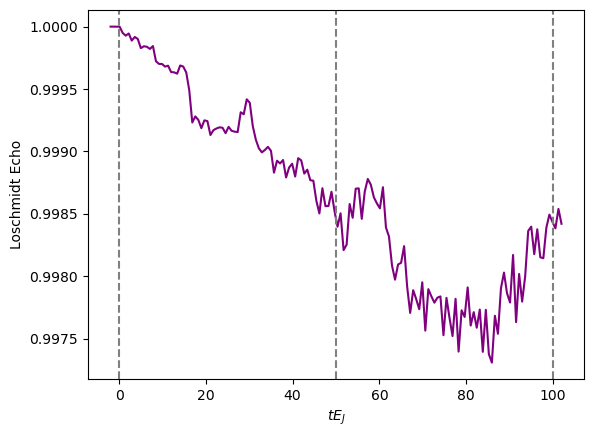

In [62]:
plt.plot(sample_times,np.abs(Loschmidt_echo),color='purple')
plt.xlabel(r'$tE_J$')
plt.ylabel(r'Loschmidt Echo')
plt.axvline(echo_times[0],linestyle='dashed',color='gray')
plt.axvline(echo_times[1],linestyle='dashed',color='gray')
plt.axvline(echo_times[2],linestyle='dashed',color='gray')
plt.show()

In [1]:
import QMC_square as qmc
import SITSpinOneMFT as sit
import numpy as np 
from scipy import integrate as intg
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as mclr


In [2]:
EJ = 1.
EC = 0.01
T = 0.1
L = 10
M = 10

nburn = 10000
nsample = 1
nstep = 1
sim = qmc.QMC(EJ,EC,T,L,M)
sim.set_sampling(nburn,nsample,nstep)

sim.burn()
sim.sample()

    

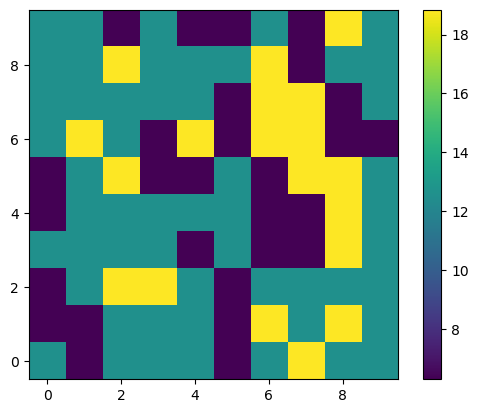

In [3]:
plt.imshow(sim.vort_samples[...,0,0],origin='lower')
plt.colorbar()
plt.show()